## Compare online ripple detection with emulated online detection (i.e., running a causal algorithm on saved data) and offline, non-causal detection.

1. Import a `.mat` file which contains arrays corresponding to the LFP and the digital IO during ripple disruption.
2. Detect ripples using the typical non-causal Hilbert transform approach
3. Run the online detection algorithm on the data to find out when ripples would have been detected in best case.
4. Compare the above results with what was actually detected.

In [1]:
import scipy.signal as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os.path
import scipy.ndimage
from itertools import groupby
from operator import itemgetter


%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')





In [2]:

data = scipy.io.loadmat(os.path.join('SampleData/thresh4.mat'),
                               struct_as_record=False, squeeze_me=True)


In [3]:
signal = data['out'].channelData
print(type(signal))

<class 'numpy.ndarray'>


In [4]:
channelData = data['digitalOut'].channelData

In [5]:
pulses = channelData[8].data

In [6]:
ts = data['out'].timestamps

In [7]:
FS = 30000

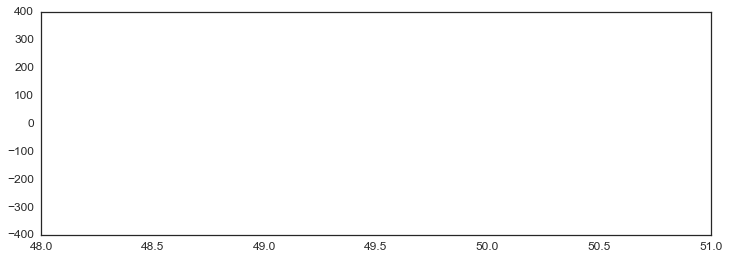

In [8]:
plt.plot(ts,signal)
plt.plot(ts,pulses*200)
plt.gca().set_xlim([48,51])
plt.show()

In [9]:
pulseidx = np.argwhere(np.diff(pulses.astype(np.int8))==1)

In [10]:
pulses[pulseidx[0]+1]

array([1], dtype=uint8)

In [11]:
1/(ts[1]-ts[0])

30000.000011793873

In [12]:

def find_threshold_crossing_events(x, threshold) :
    above_threshold = np.where(x > threshold, 1, 0);
    eventlist = []
    eventmax = []
    for k,v in groupby(enumerate(above_threshold),key=itemgetter(1)):
        if k:
            v = list(v)
            eventlist.append([v[0][0],v[-1][0]])
            try :
                eventmax.append(x[v[0][0]:(v[-1][0]+1)].max())
            except :
                print(v, x[v[0][0]:v[-1][0]])

    eventmax = np.asarray(eventmax)
    eventlist = np.asarray(eventlist)
    return eventlist, eventmax

def offline_ripple_detect(lfp, FS=1500, ThresholdSigma=3, SecondaryThresholdSigma=0, LengthCriteria=0.015):
    #  (1) filter 150-250
    #  (2) hilbert envelope
    #  (3) smooth with Gaussian (4 ms SD)
    #  (4) 3SD above the mean for 15 ms
    #  (5) full ripple defined as window back to mean


    # Generate filter for detection
    b = sp.firwin(25, [150/(FS/2), 250/(FS/2)], pass_zero=False)
    print(type(lfp))
    # Filter raw data to get ripple data
    ripple_data = sp.filtfilt(b,1,lfp)
    # Use hilbert transform to get an envelope
    ripple_envelope = np.absolute(sp.hilbert(ripple_data))

    # Smooth envelope with a gaussian
    EnvelopeSmoothingSD = 0.004 * FS
    smoothed_envelope = scipy.ndimage.filters.gaussian_filter1d(ripple_envelope, EnvelopeSmoothingSD, mode='constant')

    # Find periods where value is > mean + ThresholdSigma*SD
    Threshold = np.mean(smoothed_envelope) + ThresholdSigma*np.std(smoothed_envelope)
    ripple_events, _ = find_threshold_crossing_events(smoothed_envelope, Threshold)

    # Keep only events that are long enough (LengthCriteria s)
    ripple_events = \
        ripple_events[ripple_events[:,1] - ripple_events[:,0] >= np.round(FS*LengthCriteria),:]


    # Find periods where value is > SecondaryThreshold; note that the previous periods should be within these!
    assert SecondaryThresholdSigma < ThresholdSigma, "Secondary Threshold by definition should include more data than Primary Threshold"
    SecondaryThreshold = np.mean(smoothed_envelope) + SecondaryThresholdSigma * np.std(smoothed_envelope)
    ripple_bounds, broader_maxes = find_threshold_crossing_events(smoothed_envelope, SecondaryThreshold)

    # Find corresponding big windows for potential ripple events
    #  Specifically, look for closest left edge that is just smaller
    outer_boundary_indices = np.searchsorted(ripple_bounds[:,0], ripple_events[:,0]);
    #  searchsorted finds the index after, so subtract one to get index before
    outer_boundary_indices = outer_boundary_indices - 1;


    # Find extended boundaries for ripple events by pairing to larger windows
    #   (Note that there may be repeats if the larger window contains multiple > 3SD sections)
    ripple_bounds = ripple_bounds[outer_boundary_indices,:]
    ripple_maxes = broader_maxes[outer_boundary_indices]

    # Now, since all that we care about are the larger windows, so we should get rid of repeats
    _, unique_idx = np.unique(ripple_bounds[:,0], return_index=True)
    ripple_bounds = ripple_bounds[unique_idx,:]
    ripple_maxes = ripple_maxes[unique_idx]
    ripple_events = ripple_events[unique_idx,:]

    return ripple_bounds, ripple_maxes, ripple_events, ripple_data, ripple_envelope, smoothed_envelope


In [13]:
Threshold = 3.5 # standard deviations above the mean
print(type(signal))
ripple_events, ripple_maxes, ripple_bounds, ripple_signal, ripple_envelope, smoothed_envelope = \
    offline_ripple_detect(signal, FS=30000, ThresholdSigma=Threshold)




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [14]:
# This function does its best to match up "actual" ripples -- i.e., either gold standard or as detected by a "perfect algorithm"
#  with puttative ripples. The LargestLatency is the farthest distance (in samples) between an actual event and a putative one.
# 
# Flags:
#   AllowNonCausal - If "True", putative events can happen before actual ones (i.e., all distances are absolute value minima)
#   MaskLockouts - If "True", count as missed events that occur during the lockout period of a previous putative event. 
#                  For ease of use, we assume that the LockoutPeriod and the LargestLatency are the same.
#

def evaluate_ripple_detection(ActualEvents, PutativeEvents, LargestLatency, AllowNonCausal=False, MaskLockouts=True):
    if (AllowNonCausal):
        PotentialFalsePositives  = np.array([ActualEvents[k] for k in map(lambda x: (np.abs(ActualEvents - x)).argmin(), PutativeEvents)])
        FalsePositives = np.argwhere(np.abs(PutativeEvents - PotentialFalsePositives) > LargestLatency).squeeze()
        TruePositives = np.argwhere(np.abs(PutativeEvents - PotentialFalsePositives) <= LargestLatency).squeeze()
        
        # Get rid of repeats
        uniques, counts = np.unique(PotentialFalsePositives[TruePositives], return_counts=True)
        Mask = np.ones(TruePositives.shape,dtype=bool)
        for i, u in enumerate(uniques):
            if(counts[i] > 1):
                repeat_idx = np.argwhere(PotentialFalsePositives[TruePositives] == u).squeeze()
                best = np.abs(PotentialFalsePositives[TruePositives[repeat_idx]] - PutativeEvents[TruePositives[repeat_idx]]).argmin()
                repeat_idx = np.delete(repeat_idx, best)
                Mask[repeat_idx] = False          
        FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
        TruePositives = TruePositives[Mask]


        PotentialMisses = np.array([PutativeEvents[k] for k in map(lambda x: (np.abs(PutativeEvents - x)).argmin(), ActualEvents)])
        Misses = np.argwhere(np.abs(ActualEvents - PotentialMisses) > LargestLatency)
    else:
        PotentialFalsePositives  = np.array([ActualEvents[k] for k in map(lambda x: np.where((x - ActualEvents) >= 0, (x - ActualEvents), np.infty).argmin(), PutativeEvents)])
        FalsePositives = np.argwhere((PutativeEvents - PotentialFalsePositives > LargestLatency) | 
                                     (PutativeEvents - PotentialFalsePositives < 0)).squeeze()
        TruePositives = np.argwhere((PutativeEvents - PotentialFalsePositives <= LargestLatency) &
                                    (PutativeEvents - PotentialFalsePositives > 0)).squeeze()
        
        # Get rid of repeats
        uniques, counts = np.unique(PotentialFalsePositives[TruePositives], return_counts=True)
        Mask = np.ones(TruePositives.shape,dtype=bool)
        for i, u in enumerate(uniques):
            if(counts[i] > 1):
                repeat_idx = np.argwhere(PotentialFalsePositives[TruePositives] == u).squeeze()
                best = (PutativeEvents[TruePositives[repeat_idx]] - PotentialFalsePositives[TruePositives[repeat_idx]]).argmin()
                repeat_idx = np.delete(repeat_idx, best)
                Mask[repeat_idx] = False          
        FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
        TruePositives = TruePositives[Mask]
        
        # Potentially look for lockout periods that might have blocked detection (in low threshold cases)
        # Assuming LockoutPeriod and LargestLatency are the same!!!!!
        if (MaskLockouts):
            Mask = np.ones(TruePositives.shape,dtype=bool)
            for idx,k in enumerate(TruePositives):
                if (k > 0):
                    # Flag events where the previous putative event was within a lockout period of the actual event
                    if ((PotentialFalsePositives[k] - PutativeEvents[k - 1]) < LargestLatency) :
                        Mask[idx] = False
            FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
            TruePositives = TruePositives[Mask]

        PotentialMisses = np.array([PutativeEvents[k] for k in map(lambda x: (np.where(PutativeEvents - x >= 0, PutativeEvents - x, np.infty)).argmin(), ActualEvents)])
        Misses = np.argwhere(PotentialMisses - ActualEvents > LargestLatency).squeeze()

    Latencies = PutativeEvents[TruePositives] - PotentialFalsePositives[TruePositives]
    
    return FalsePositives, TruePositives, Latencies, Misses



In [15]:
ripple_events.shape

(35, 2)

In [16]:
falsepositives, truepositives, latencies, _ = \
    evaluate_ripple_detection(ripple_events[:,0],pulseidx.squeeze()+1,30000*0.25,MaskLockouts=False)

print(latencies.mean()/30000)
print(truepositives.shape)

0.0524104761905
(35,)


In [17]:
np.median(ripple_bounds[:,0] - ripple_events[:,0])

771.0

In [18]:
def ripple_processor(data, FS=1500, TrainingPeriod=120*FS, ThresholdSigma=4, LockoutPeriod=0.25*FS, Algorithm="unsmooth"):
    def find_events(d, Thresh, TrainBnd, LckPd):
        events = np.argwhere(d > Thresh)
        # get rid of events that happened during training
        events = events[events >= TrainBnd]
        # get rid of events which lie within the Lockout period of previous events
        mask = np.ones(len(events), dtype=bool)
        last = -LckPd -1
        for k, ev in enumerate(events):
            if (ev < last + LckPd):
                mask[k] = False
            else:
                last = ev
        events = events[mask]
        return events

    TrBnd = np.rint(TrainingPeriod).astype(int)
    LckPd = np.rint(LockoutPeriod)
    b, a = sp.butter(4, [150/(FS/2), 250/(FS/2)], btype='bandpass')
    ripple_band = sp.lfilter(b, a, data) # causal fitler of signal
    
    if (Algorithm.lower()=="unsmooth"):
        ripple_signal = np.abs(ripple_band)
        mu = np.mean(ripple_signal[:TrBnd])
        sd = np.std(ripple_signal[:TrBnd])
        ripple_events = find_events(ripple_signal, mu + ThresholdSigma*sd, TrBnd, LckPd)
    
    elif (Algorithm.lower()=="smooth"):
        bsmooth, asmooth = sp.butter(2, 50/(FS/2), btype='lowpass')
        ripple_signal = sp.lfilter(bsmooth, asmooth, np.abs(ripple_band)) #smooth it
        mu = np.mean(ripple_signal[:TrBnd])
        sd = np.std(ripple_signal[:TrBnd])
        ripple_events = find_events(ripple_signal, mu + ThresholdSigma*sd, TrBnd, LckPd)
        
    elif (Algorithm.lower()=="hbt"):
        g = np.zeros(20)
        gptr = 0
        last_stim = 0
        def updateGain(d, g, gptr):
            mn = g.mean()
            g[gptr] = d
            gptr = gptr + 1 if (gptr < 19) else 0
            return mn, g, gptr
        
        mu = 0
        sd = 0
        ripple_events = []
        v = np.zeros(ripple_band.shape)
        # Algorithm from Jadhav et al Science 2012
        for k, x in enumerate(ripple_band):
            if (k > 0):
                df = x - v[k-1]
            else:
                df = x

            if (df > 0):
                gain, g, gptr = updateGain(1.2, g, gptr)
                v[k] = v[k-1] + gain * df
            else:
                _, g, gptr = updateGain(2.0, g, gptr)
                v[k] = v[k-1] + 2.0 * df
                
            mu = mu + (x - mu) / 10000
            sd = (np.abs(x - mu) - sd) / 10000 + sd
            if ((k > TrBnd) & ((k-last_stim) > LckPd)) :
                if (v[k] > mu + ThresholdSigma*sd) :
                    ripple_events.append(k)
                    last_stim = k
        ripple_events = np.array(ripple_events)
        ripple_signal = v
    else:
        raise ValueError("Unknown algorithm specified")
    
    return ripple_events, ripple_signal, mu, sd, ripple_band


In [19]:
rip_evs, _, _, _, _ = ripple_processor(signal, FS=30000, Algorithm='smooth', TrainingPeriod=60*30000)

In [20]:
fp2, tp2, lat2, _ = evaluate_ripple_detection(ripple_events[:,0],rip_evs,30000*0.25,MaskLockouts=False)

print(lat2.mean()/30000)
print(tp2.shape)

0.0409866666667
(25,)


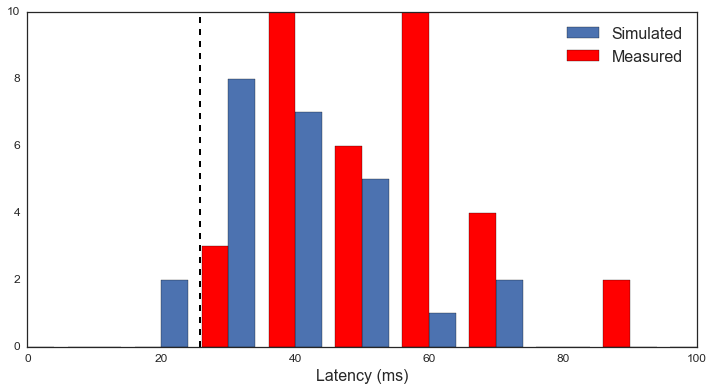

In [25]:
bins = (np.arange(0,200,10)-5)/1000
hist, _ = np.histogram(latencies/30000, bins=bins)
width = 0.4 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

hist2, _ = np.histogram(lat2/30000, bins=bins)

sns.set(rc={'figure.figsize': (12, 6),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')

plt.bar(center*1000, hist2, align='edge', width=width*1000, label='Simulated')
plt.bar(center*1000, hist, align='edge', width=-width*1000, color='r', label='Measured')
plt.plot(np.median(ripple_bounds[:,0] - ripple_events[:,0])*np.ones(2)*1000/30000, [0, 10], 'k--')
plt.gca().set_xlabel('Latency (ms)')
plt.gca().set_xlim([0, 100])
plt.legend()
plt.show()
